<a href="https://colab.research.google.com/github/Maqar/Computer-Vision/blob/main/HW1_MLDM_2020_seminar11_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

In [ ]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_datasets as tfds
from tqdm import tqdm

from PIL import Image

2.3.0


In [ ]:
lfw = tfds.image_classification.LFW()
lfw.download_and_prepare()
ds = lfw.as_dataset()

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incomplete75IEH1/lfw-train.tfrecord


Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [ ]:
def get_img(x):
  return x['image'][80:-80,80:-80]

data = np.array([
  np.array(Image.fromarray(img.numpy()).resize((36, 36)))
  for img in tqdm(ds['train'].map(get_img))
])

100%|██████████| 13233/13233 [00:11<00:00, 1173.55it/s]


In [ ]:
data.shape

(13233, 36, 36, 3)

In [ ]:
import matplotlib.pyplot as plt

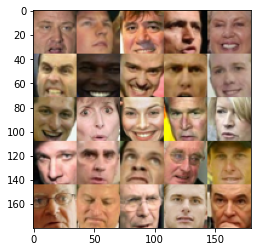

In [ ]:
plt.imshow(data[:25].reshape(5, 5, 36, 36, 3).transpose((0, 2, 1, 3, 4)).reshape(5 * 36, 5 * 36, 3));

In [ ]:
X_train = data.astype('float32') / 255
print(X_train.min(), X_train.max(), X_train.dtype)

0.0 1.0 float32


In [ ]:
ll = tf.keras.layers

LATENT_DIM = 100

generator = tf.keras.Sequential([
  ll.Dense(48*48*3, input_shape=(LATENT_DIM,)),
  ll.BatchNormalization(),
  ll.LeakyReLU(),
  
  ll.Reshape((48, 48, 3)),

  ll.Conv2D(128, (5,5)),
  ll.BatchNormalization(),
  ll.LeakyReLU(),

  ll.Conv2D(64, (5,5)),
  ll.BatchNormalization(),
  ll.LeakyReLU(),
  
  ll.Conv2D(3, (5,5), activation='tanh'),

  #Con,Batch,Selu*3,Con,Tanh
])

discriminator = tf.keras.Sequential([
  ll.Conv2D(64, (5,5), input_shape=(36, 36, 3)),
  ll.LeakyReLU(),
  ll.Dropout(0.1),

  ll.Conv2D(128, (5,5)),
  ll.LeakyReLU(),
  ll.Dropout(0.1),

  ll.Flatten(),
  ll.Dense(1),

  #Con,Selu,Con,B,Selu*2,Con,Sig
])

generator.summary()
discriminator.summary()

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 6912)              698112    
_________________________________________________________________
batch_normalization_155 (Bat (None, 6912)              27648     
_________________________________________________________________
leaky_re_lu_342 (LeakyReLU)  (None, 6912)              0         
_________________________________________________________________
reshape_76 (Reshape)         (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 44, 44, 128)       9728      
_________________________________________________________________
batch_normalization_156 (Bat (None, 44, 44, 128)       512       
_________________________________________________________________
leaky_re_lu_343 (LeakyReLU)  (None, 44, 44, 128)    

In [ ]:
def gen_images(num):
  return generator(tf.random.normal(shape=(num, LATENT_DIM)))

@tf.function
def forward(batch):
  real = batch
  fake = gen_images(len(batch))

  shape = (len(batch), 1)
  labels_real = tf.ones (shape=shape)
  
  labels_fake = tf.zeros(shape=shape)

  X = tf.concat([real, fake], axis=0)
  y = tf.concat([labels_real, labels_fake], axis=0)

  
  loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(y, discriminator(X, training=True))
  )
  return loss

opt_d = tf.optimizers.RMSprop()
opt_g = tf.optimizers.RMSprop()

@tf.function
def disc_step(batch):
  with tf.GradientTape() as t:
    d_loss = forward(batch)
  grads = t.gradient(d_loss, discriminator.trainable_variables)
  opt_d.apply_gradients(zip(grads, discriminator.trainable_variables))
  return d_loss

@tf.function
def gen_step(batch):
  with tf.GradientTape() as t:
    g_loss = -forward(batch)
  grads = t.gradient(g_loss, generator.trainable_variables)
  opt_g.apply_gradients(zip(grads, generator.trainable_variables))
  return g_loss

Finally, let's write our training loop:

In [ ]:
from IPython.display import clear_output
from tqdm import trange

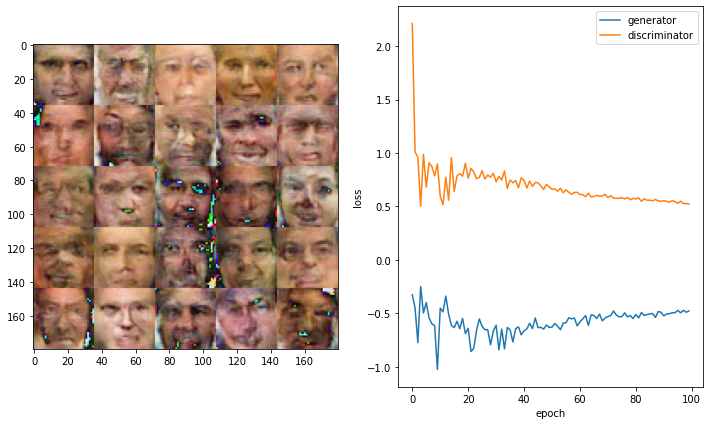

Done with epoch # 99


In [ ]:
BATCH_SIZE = 256

N_EPOCHS = 100
NUM_DISC_STEPS = 5

i_disc_step = 0
losses_gen = []
losses_disc = []
for i_ep in range(N_EPOCHS):
  shuffle_ids = np.random.choice(len(X_train), len(X_train), replace=False)
  epoch_loss_gen = []
  epoch_loss_disc = []
  for i_img in trange(0, len(X_train), BATCH_SIZE):
    batch = X_train[shuffle_ids][i_img:i_img + BATCH_SIZE]

    if i_disc_step < NUM_DISC_STEPS:
      i_disc_step += 1
      epoch_loss_disc.append(disc_step(batch).numpy())
    else:
      i_disc_step = 0
      epoch_loss_gen.append(gen_step(batch).numpy())

  losses_gen.append(np.mean(epoch_loss_gen))
  losses_disc.append(np.mean(epoch_loss_disc))

  opt_d.learning_rate.assign(opt_d.learning_rate * 0.99)
  opt_g.learning_rate.assign(opt_g.learning_rate * 0.99)

  imgs = (gen_images(25).numpy() * 255).astype('uint8')
  clear_output(wait=True)
  plt.figure(figsize=(12, 7))
  plt.subplot(1, 2, 1)
  plt.imshow(imgs.reshape((5, 5, 36, 36, 3)).transpose(0, 2, 1, 3, 4).reshape(36 * 5, 36 * 5, 3))
  plt.subplot(1, 2, 2)
  plt.plot(losses_gen, label='generator')
  plt.plot(losses_disc, label='discriminator')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print("Done with epoch #", i_ep)